# Discrete Models for Identification Algorithm Development

In causal inference we are often concerned with performing identification, which is determining whether a causal query is a function of the observed data. Algorithms have been developed to address these questions in a variety of settings. When developing new algorithms for identification, the first aspect is soundness - whether an algorithm correctly returns the causal effect.

In this notebook we outline some helpful tools intended to assist in the development of such algorithms. The principle idea is to construct a causal model in a directed acyclic graph using `pgmpy.models.BayesianNetwork` for this purpose. Given this causal model, we can directly introduce an intervention, and then compute the causal query in the intervened distribution. Then, we can pass the observed data distribution from the causal model into a proposed identification algorithm, and verify that the result agrees with the computed truth.

This development pattern should be useful for both checking correctness of proposed identification algorithms, and also serve as a concrete implementation for understanding how causal identification works.

In [1]:
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork

from ananke.graphs import ADMG, DAG
from ananke.identification import OneLineID
from ananke.models import discrete

## Front-door graph

We first consider the simple case of the front-door graph. In this example we demonstrate the API which implements the ID algorithm (Shpitser and Pearl, 2006).

We initialize an ADMG representing this graph, and provide variable cardinalities.

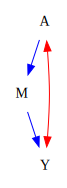

In [2]:
di_edges = [("A", "M"), ("M", "Y")]
bi_edges = [("A", "Y")]
graph = ADMG(vertices={"A": 2, "M": 2, "Y": 2}, di_edges=di_edges, bi_edges=bi_edges)
graph.draw()

This distribution is an ADMG, which has bidirected edges representing unmeasured confounding. To continue, we convert this ADMG into its canonical DAG form, which replaces each bidirected edge with a single hidden variable.

In [3]:
dag = graph.canonical_dag(cardinality=2)

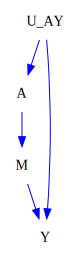

In [4]:
dag.draw()

Next, we generate conditional probability distributions consistent with this graph. This provides a causal model with factorization $$ p(A, M, Y, U_{A, Y}) = p(Y | M, U_{A,Y}) p(A | U_{A, Y}) p(M | A) p(U_{A, Y})$$

We represent this as `net`.

In [5]:
cpds = discrete.generate_random_cpds(graph=dag, dir_conc=10)
net = discrete.generate_bayesian_network(graph=dag, cpds=cpds)

We are next interested in a causal model where $do(A=1)$ has been implemented. Then,
$$p(Y(a=1), M(a=1), U_{A, Y}(a=1)) = p(Y | M, U_{A,Y})  p(M | A=1) p(U_{A, Y})$$

We represent this as `int_net`.

In [6]:
treatment_dict = {"A": 1}
outcome_dict = {"Y": 1}

In this model, the causal effect $p(Y(a=1)=1)$ is simply the marginal distribution evaluated at $Y=1$:

In [7]:
truth = discrete.compute_effect_from_discrete_model(net, treatment_dict, outcome_dict)

INFO:root:Replacing existing CPD for A


We can also compute the causal effect directly from the observed data distribution.

In [8]:
oid = OneLineID(graph, list(treatment_dict), list(outcome_dict))

In [9]:
result = discrete.estimate_effect_from_discrete_dist(
    oid, net, treatment_dict, outcome_dict
)

In [10]:
print("Effect computed through intervention of model:  ", truth)
print("Effect computed through identification algorithm: ", result)

Effect computed through intervention of model:   0.5737395621128467
Effect computed through identification algorithm:  0.5737395621128466


The result agrees with the truth up to floating point precision.

## Conditional Ignorability 

We demonstrate this example to show off how a user might compute identification queries using a lower level interface. This is useful if the developed identification algorithm does not align with the format of the ID algorithm.

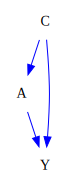

In [11]:

di_edges = [("A", "Y"), ("C", "Y"), ("C", "A")]
bi_edges = []
c_graph  = ADMG(vertices={"A": 2, "C": 2, "Y": 2}, di_edges=di_edges, bi_edges=bi_edges)
c_graph.draw()

In [12]:
c_dag = c_graph.canonical_dag(cardinality=2)

In [13]:
cpds = discrete.generate_random_cpds(graph=c_dag, dir_conc=10)
net = discrete.generate_bayesian_network(graph=c_dag, cpds=cpds)

We first set up an intervened version of the model, with the desired intervention $do(A=1)$.

In [14]:
treatment_dict = {"A": 1}
outcome_dict = {"Y": 1}

int_net = discrete.intervene(net, treatment_dict)
int_inference = VariableElimination(int_net)

INFO:root:Replacing existing CPD for A


Then we compute the marginal of $Y$ in this distribution which is the causal parameter of interest $p(Y(a=1))$. This gives us the truth.

In [15]:
truth = int_inference.query(["Y"]).get_value(**outcome_dict)


To compute the causal effect another way, we use only the observed data distribution and implement the g-formula result:
$$ p(Y(a=1)) = \sum_C p(Y | A=1, C) p(C) $$


In [16]:
inference = VariableElimination(net)

In [17]:
p_YAC = inference.query(["Y", "A", "C"])
p_Y_AC = p_YAC.divide(p_YAC.marginalize(["Y"], inplace=False), inplace=False)
p_Y_A1C = p_Y_AC.reduce([("A", 1)], inplace=False)
p_C = p_YAC.marginalize(["A", "Y"], inplace=False)
p_Y_do_A1 = p_Y_A1C.product(p_C, inplace=False).marginalize(["C"], inplace=False)

In [18]:
result = p_Y_do_A1.get_value(**outcome_dict)

In [19]:
print("Effect computed through intervention of model:  ", truth)
print("Effect computed through identification algorithm: ", result)

Effect computed through intervention of model:   0.4861312929598295
Effect computed through identification algorithm:  0.4861312929598294


Again, the result agrees with the truth up to floating point precision.